In [412]:
import torch
import torchaudio

print(f"PyTorch version: {torch.__version__}")
print(f"TorchAudio version: {torchaudio.__version__}")

# Apple Silicon MPS GPU 사용 설정
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Apple Silicon M4 GPU (MPS)")
else:
    device = torch.device("cpu")
    print("MPS 사용 불가, CPU 사용")

print(f"Device: {device}")


PyTorch version: 2.8.0
TorchAudio version: 2.8.0
Apple Silicon M4 GPU (MPS)
Device: mps


In [413]:
# 전체 라이브러리 임포트 및 설정
import io
import os
import glob
import math
import timeit
import warnings
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from IPython.display import Audio

# 로컬 오디오 파일 지원을 위한 librosa 임포트
try:
    import librosa
    import resampy
    LIBROSA_AVAILABLE = True
    print("M4A 파일 지원을 위한 librosa 로드 완료")
except ImportError:
    LIBROSA_AVAILABLE = False
    print("librosa 없음 - M4A 파일 지원 제한")

# 설정
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore", category=UserWarning, module="torchaudio")
warnings.filterwarnings("ignore", category=UserWarning, module="librosa")

print("모든 라이브러리 임포트 완료")


M4A 파일 지원을 위한 librosa 로드 완료
모든 라이브러리 임포트 완료


In [414]:
# 로컬 오디오 파일 로딩 (M4A 지원)
def load_local_audio_files():
    """로컬 audio_dataset 폴더에서 오디오 파일들을 찾습니다"""
    audio_files = []
    dataset_path = "./audio_dataset"
    supported_formats = ['*.wav', '*.mp3', '*.m4a', '*.flac']
    
    print(f"=== {dataset_path} 폴더에서 오디오 파일 검색 ===")
    
    for format_pattern in supported_formats:
        files = glob.glob(os.path.join(dataset_path, format_pattern))
        audio_files.extend(files)
    
    if audio_files:
        print(f"{len(audio_files)}개의 오디오 파일:")
        for file in audio_files[:5]:  # 처음 5개만 표시
            print(f"  - {os.path.basename(file)}")
        if len(audio_files) > 5:
            print(f"  ... 및 {len(audio_files) - 5}개 더")
        return audio_files
    else:
        print(f"{dataset_path} 폴더에서 오디오 파일을 찾을 수 없습니다.")
        return []

# 로컬 파일 검색
AUDIO_FILES = load_local_audio_files()

# 테스트 샘플 생성 함수
def create_test_sample(sample_rate=16000, duration=3.0, frequency=440):
    """테스트용 사인파 생성 (MPS 가속)"""
    t = torch.linspace(0, duration, int(sample_rate * duration), device=device)
    waveform = torch.sin(2 * torch.pi * frequency * t).unsqueeze(0)
    return waveform, sample_rate

# 샘플 오디오 준비
if AUDIO_FILES:
    print(f"로컬 파일 사용: {os.path.basename(AUDIO_FILES[0])}")
    SAMPLE_PATH = AUDIO_FILES[0]
else:
    print("테스트 샘플 생성")
    SAMPLE_WAVEFORM, SAMPLE_RATE = create_test_sample()
    SAMPLE_PATH = None


=== ./audio_dataset 폴더에서 오디오 파일 검색 ===
4개의 오디오 파일:
  - 095522041.m4a
  - 095522040.m4a
  - 095522042.m4a
  - 095522039.m4a
로컬 파일 사용: 095522041.m4a


In [415]:
# MPS 안전 오디오 로딩 함수
def safe_load_audio(file_path, target_sample_rate=16000):
    """MPS 호환 오디오 로딩 (M4A 지원)"""
    if file_path is None:
        # 테스트 샘플 반환
        return create_test_sample(target_sample_rate)
    
    try:
        print(f"로딩 중: {os.path.basename(file_path)}")
        
        # M4A 파일 처리
        if file_path.lower().endswith('.m4a') and LIBROSA_AVAILABLE:
            try:
                print("librosa를 사용해 M4A 파일 로드 중...")
                audio_data, sr = librosa.load(file_path, sr=None)
                
                # NumPy to Torch 안전 변환
                try:
                    waveform = torch.from_numpy(audio_data).unsqueeze(0).float()
                except RuntimeError:
                    # MPS NumPy 호환성 문제 해결
                    audio_list = audio_data.tolist()
                    waveform = torch.tensor(audio_list, dtype=torch.float32).unsqueeze(0)
                
                print(f"librosa 로드 성공 ({sr}Hz)")
                return waveform, sr
                
            except Exception as e:
                print(f"librosa 실패: {e}")
        
        # 일반 오디오 파일 (WAV, MP3 등)
        try:
            waveform, sample_rate = torchaudio.load(file_path)
            print(f"torchaudio 로드 성공 ({sample_rate}Hz)")
            return waveform, sample_rate
        except Exception as e:
            print(f"torchaudio 실패: {e}")
            
    except Exception as e:
        print(f"오디오 로드 실패: {e}")
    
    # 실패 시 테스트 샘플 생성
    print("테스트 샘플 생성으로 대체")
    return create_test_sample(target_sample_rate)

# 샘플 오디오 로드
if SAMPLE_PATH:
    waveform, sample_rate = safe_load_audio(SAMPLE_PATH)
else:
    waveform, sample_rate = SAMPLE_WAVEFORM, SAMPLE_RATE

# GPU로 이동
waveform = waveform.to(device)

print(f"로드된 오디오 정보:")
print(f"  - 샘플링 레이트: {sample_rate} Hz")
print(f"  - 채널 수: {waveform.shape[0]}")
print(f"  - 길이: {waveform.shape[1]} 샘플 ({waveform.shape[1]/sample_rate:.2f}초)")
print(f"  - 디바이스: {waveform.device}")


로딩 중: 095522041.m4a
librosa를 사용해 M4A 파일 로드 중...
librosa 로드 성공 (44100Hz)
로드된 오디오 정보:
  - 샘플링 레이트: 44100 Hz
  - 채널 수: 1
  - 길이: 176400 샘플 (4.00초)
  - 디바이스: mps:0


/var/folders/xv/gnxr9h8s02z_grk0h3vstfdh0000gn/T/ipykernel_27022/2919392219.py:15: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path, sr=None)
/Users/songdongseon/AI/.venv/lib/python3.13/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [416]:
# MPS 안전 NumPy 변환 함수
def safe_numpy_convert(tensor):
    if tensor is None:
        return np.array([0])
    
    try:
        # CPU로 이동 후 변환
        if hasattr(tensor, 'device') and tensor.device.type in ['mps', 'cuda']:
            tensor = tensor.cpu()
        return tensor.numpy()
    except Exception as e:
        print(f"NumPy 변환 실패, 리스트 변환 시도: {e}")
        try:
            # 리스트 경유 변환
            if hasattr(tensor, 'device') and tensor.device.type in ['mps', 'cuda']:
                tensor = tensor.cpu()
            return np.array(tensor.tolist())
        except Exception as e2:
            print(f"모든 변환 실패, 더미 데이터 생성: {e2}")
            # 최후의 수단: 더미 데이터
            return np.sin(2 * np.pi * 440 * np.linspace(0, 3, 48000)).reshape(1, -1)

print("안전한 NumPy 변환 함수 정의 완료")


안전한 NumPy 변환 함수 정의 완료


In [417]:
# Waveform 시각화 함수 (MPS 안전)
def plot_waveform(waveform, sample_rate, title="Waveform"):
    
    # 안전한 NumPy 변환
    waveform_np = safe_numpy_convert(waveform)
    
    # 차원 확인 및 조정
    if len(waveform_np.shape) == 1:
        waveform_np = waveform_np.reshape(1, -1)
    
    num_channels, num_frames = waveform_np.shape
    time_axis = np.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1, figsize=(12, 4))
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform_np[c], linewidth=1, color='blue')
        axes[c].grid(True, alpha=0.3)
        axes[c].set_ylabel("Amplitude")
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    
    axes[-1].set_xlabel("Time (seconds)")
    figure.suptitle(title)
    plt.tight_layout()
    plt.show()

print("Waveform 시각화 함수 정의 완료")


Waveform 시각화 함수 정의 완료


NumPy 변환 실패, 리스트 변환 시도: Numpy is not available


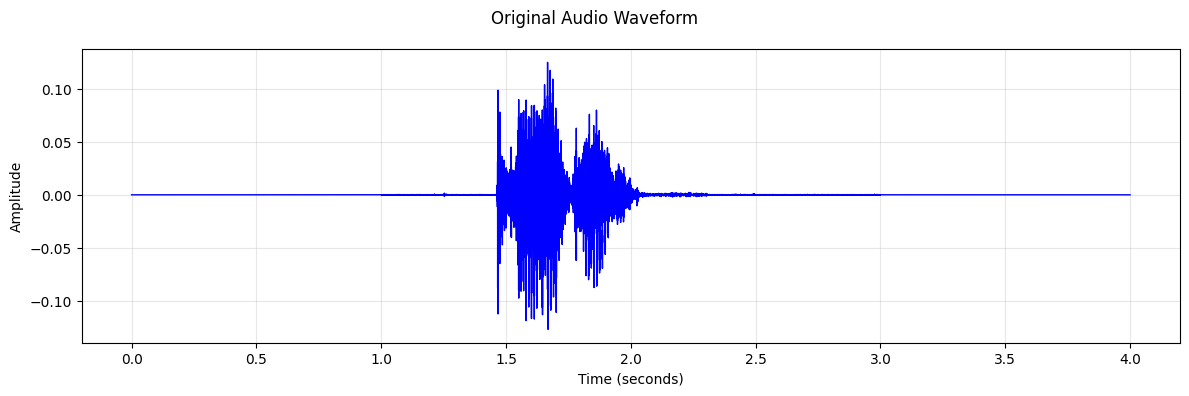

In [418]:
# 원본 오디오 Waveform 시각화
plot_waveform(waveform, sample_rate, "Original Audio Waveform")

In [419]:
# Spectrogram 시각화 함수 (MPS 안전)
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform_np = safe_numpy_convert(waveform)
    
    # 차원 확인 및 조정
    if len(waveform_np.shape) == 1:
        waveform_np = waveform_np.reshape(1, -1)

    num_channels, num_frames = waveform_np.shape

    figure, axes = plt.subplots(num_channels, 1, figsize=(12, 6))
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform_np[c], Fs=sample_rate, cmap='viridis')
        axes[c].set_ylabel("Frequency (Hz)")
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1} Frequency (Hz)")
    
    axes[-1].set_xlabel("Time (seconds)")
    figure.suptitle(title)
    plt.tight_layout()
    plt.show()

print("Spectrogram 시각화 함수 정의 완료")


Spectrogram 시각화 함수 정의 완료


NumPy 변환 실패, 리스트 변환 시도: Numpy is not available


/Users/songdongseon/AI/.venv/lib/python3.13/site-packages/matplotlib/axes/_axes.py:8283: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


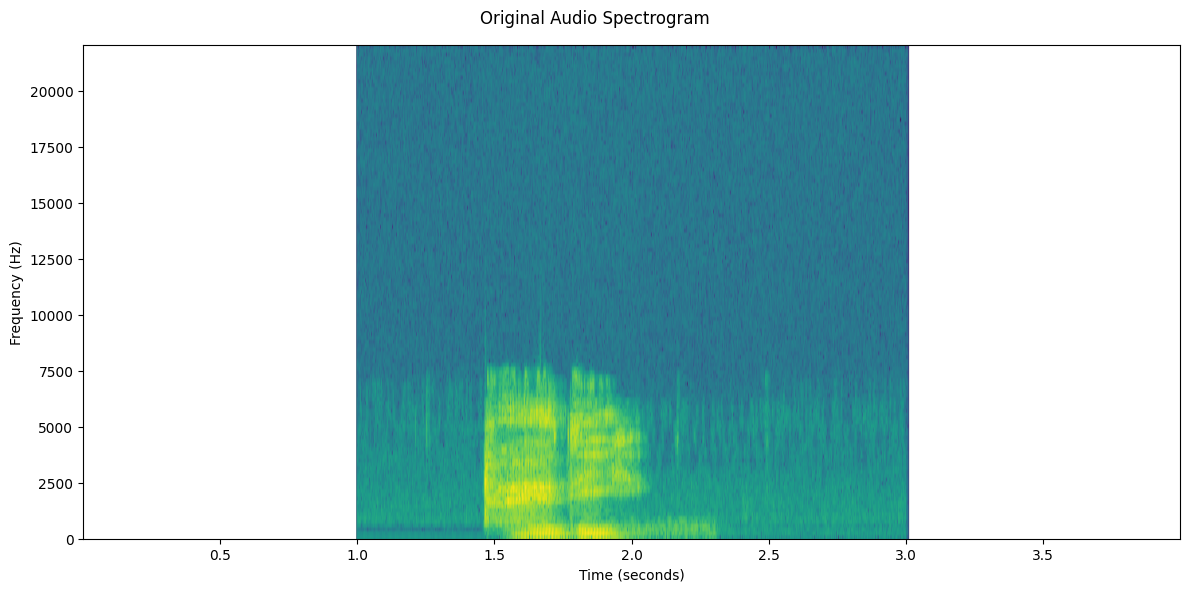

In [420]:
# 원본 오디오 Spectrogram 시각화
plot_specgram(waveform, sample_rate, "Original Audio Spectrogram")

In [421]:
# 오디오 재생 (MPS 안전)
def safe_audio_play(waveform, sample_rate):
    """MPS 안전 오디오 재생"""
    if waveform is None:
        print("waveform이 None")
        return None
    
    waveform_np = safe_numpy_convert(waveform)
    if len(waveform_np.shape) > 1:
        waveform_np = waveform_np[0]  # 첫 번째 채널만 사용
    
    try:
        return Audio(waveform_np, rate=sample_rate)
    except Exception as e:
        print(f"오디오 재생 실패: {e}")
        return None

# 원본 오디오 재생
print("원본 오디오 재생:")
audio_widget = safe_audio_play(waveform, sample_rate)
if audio_widget:
    audio_widget


원본 오디오 재생:
NumPy 변환 실패, 리스트 변환 시도: Numpy is not available


In [422]:
# Sine Sweep 생성 함수들 (AIweek3.ipynb 기반, MPS 최적화)
DEFAULT_OFFSET = 201

def _get_log_freq(sample_rate, max_sweep_rate, offset):
    """로그 스케일 주파수 생성 (MPS 호환)"""
    start, stop = math.log(offset), math.log(offset + max_sweep_rate // 2)
    # MPS는 float64를 지원하지 않으므로 float32 사용
    return torch.exp(torch.linspace(start, stop, sample_rate, dtype=torch.float32, device=device)) - offset

def _get_inverse_log_freq(freq, sample_rate, offset):
    """역 로그 주파수 계산"""
    half = sample_rate // 2
    return sample_rate * (math.log(1 + freq / offset) / math.log(1 + half / offset))

def _get_freq_ticks(sample_rate, offset, f_max):
    """주파수 눈금 계산"""
    times, freq = [], []
    for exp in range(2, 5):
        for v in range(1, 10):
            f = v * 10**exp
            if f < sample_rate // 2:
                t = _get_inverse_log_freq(f, sample_rate, offset) / sample_rate
                times.append(t)
                freq.append(f)
    t_max = _get_inverse_log_freq(f_max, sample_rate, offset) / sample_rate
    times.append(t_max)
    freq.append(f_max)
    return times, freq

def get_sine_sweep(sample_rate, offset=DEFAULT_OFFSET):
    """로그 스케일 사인 스윕 생성 (MPS 가속)"""
    max_sweep_rate = sample_rate
    freq = _get_log_freq(sample_rate, max_sweep_rate, offset)
    delta = 2 * math.pi * freq / sample_rate
    cummulative = torch.cumsum(delta, dim=0)
    signal = torch.sin(cummulative).unsqueeze(dim=0)
    return signal

def plot_sweep(waveform, sample_rate, title, max_sweep_rate=48000, offset=DEFAULT_OFFSET):
    """Sine Sweep 시각화 (MPS 안전)"""
    print(f"{title} Sweep 시각화 중...")
    
    # 안전한 NumPy 변환
    waveform_np = safe_numpy_convert(waveform)
    if len(waveform_np.shape) > 1:
        waveform_np = waveform_np[0]
    
    x_ticks = [100, 500, 1000, 5000, 10000, 20000, max_sweep_rate // 2]
    y_ticks = [1000, 5000, 10000, 20000, sample_rate // 2]

    time, freq = _get_freq_ticks(max_sweep_rate, offset, sample_rate // 2)
    freq_x = [f if f in x_ticks and f <= max_sweep_rate // 2 else None for f in freq]
    freq_y = [f for f in freq if f in y_ticks and 1000 <= f <= sample_rate // 2]

    figure, axis = plt.subplots(1, 1, figsize=(12, 8))
    try:
        _, _, _, cax = axis.specgram(waveform_np, Fs=sample_rate, cmap='viridis')
        plt.xticks(time, freq_x)
        plt.yticks(freq_y, freq_y)
        axis.set_xlabel("Original Signal Frequency (Hz, log scale)")
        axis.set_ylabel("Waveform Frequency (Hz)")
        axis.xaxis.grid(True, alpha=0.67)
        axis.yaxis.grid(True, alpha=0.67)
        figure.suptitle(f"{title} (sample rate: {sample_rate} Hz)")
        if cax is not None:
            plt.colorbar(cax)
        plt.tight_layout()
        plt.show()
        print("Sweep 시각화 완료!")
    except Exception as e:
        print(f"Sweep 시각화 실패: {e}")
        # 대체: 일반 waveform 플롯
        plot_waveform(waveform, sample_rate, f"{title} (Fallback)")

print("Sine Sweep 함수들 정의 완료")


Sine Sweep 함수들 정의 완료


Sine Sweep 생성 완료 (48000Hz)
Shape: torch.Size([1, 48000])
Device: mps:0
Original Sine Sweep Sweep 시각화 중...
NumPy 변환 실패, 리스트 변환 시도: Numpy is not available


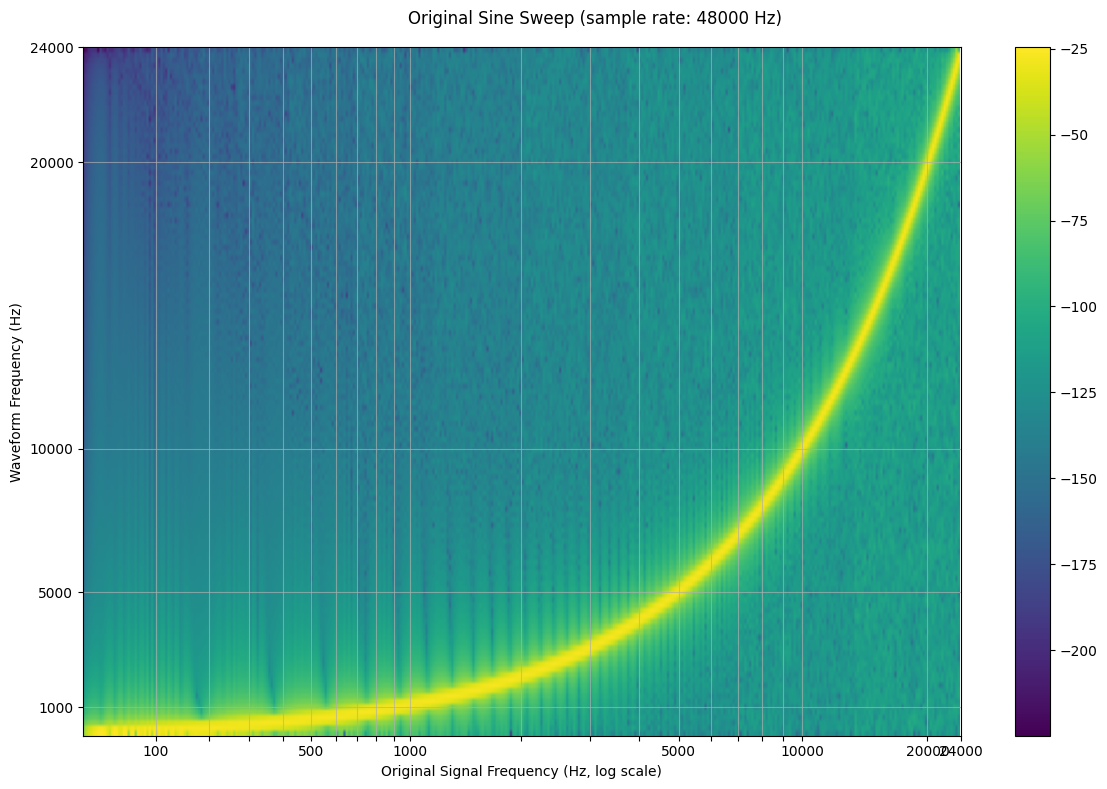

Sweep 시각화 완료!
Sine Sweep 재생:
NumPy 변환 실패, 리스트 변환 시도: Numpy is not available


In [423]:
# Sine Sweep 생성 및 시각화 (AIweek3.ipynb와 동일)
sample_rate = 48000
waveform_sweep = get_sine_sweep(sample_rate)

print(f"Sine Sweep 생성 완료 ({sample_rate}Hz)")
print(f"Shape: {waveform_sweep.shape}")
print(f"Device: {waveform_sweep.device}")

plot_sweep(waveform_sweep, sample_rate, title="Original Sine Sweep")

# Sine Sweep 오디오 재생
print("Sine Sweep 재생:")
sweep_audio = safe_audio_play(waveform_sweep, sample_rate)
if sweep_audio:
    sweep_audio


Transform 리샘플링: 48000Hz → 32000Hz
리샘플링 완료
원본 Shape: torch.Size([1, 48000])
리샘플링 Shape: torch.Size([1, 32000])
Resampled Waveform Sweep 시각화 중...
NumPy 변환 실패, 리스트 변환 시도: Numpy is not available


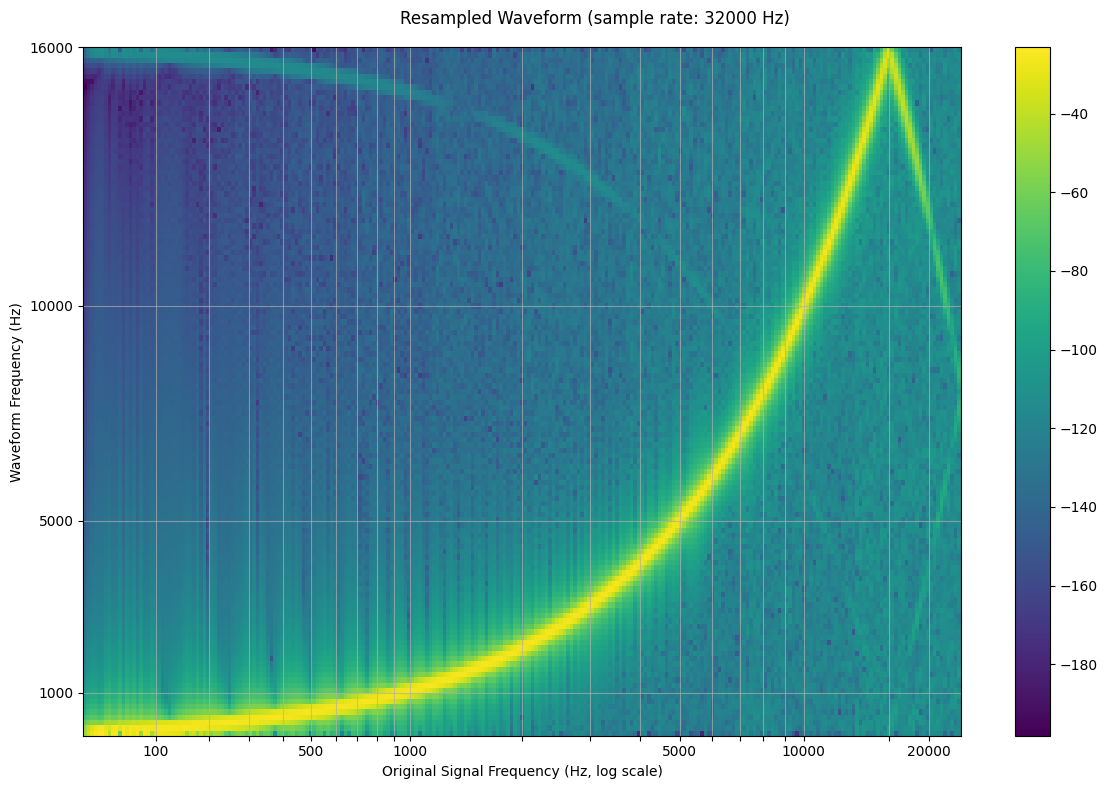

Sweep 시각화 완료!
리샘플링된 오디오 재생:
NumPy 변환 실패, 리스트 변환 시도: Numpy is not available


In [424]:
# Transform 기반 리샘플링 (AIweek3.ipynb와 동일)
resample_rate = 32000
print(f"Transform 리샘플링: {sample_rate}Hz → {resample_rate}Hz")

resampler = T.Resample(sample_rate, resample_rate, dtype=waveform_sweep.dtype).to(device)
resampled_waveform = resampler(waveform_sweep)

print(f"리샘플링 완료")
print(f"원본 Shape: {waveform_sweep.shape}")
print(f"리샘플링 Shape: {resampled_waveform.shape}")

plot_sweep(resampled_waveform, resample_rate, title="Resampled Waveform")

# 리샘플링된 오디오 재생
print("리샘플링된 오디오 재생:")
resampled_audio = safe_audio_play(resampled_waveform, resample_rate)
if resampled_audio:
    resampled_audio


lowpass_filter_width 파라미터 비교

lowpass_filter_width=6 테스트:
lowpass_filter_width=6 Sweep 시각화 중...
NumPy 변환 실패, 리스트 변환 시도: Numpy is not available


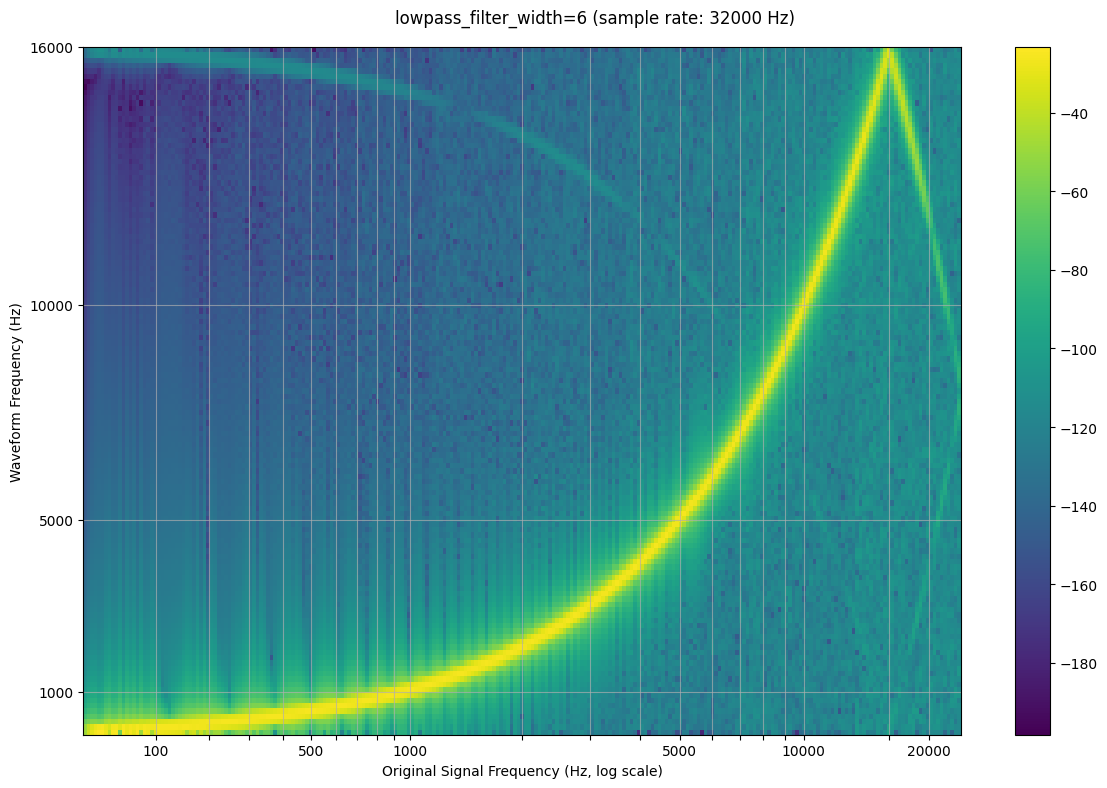

Sweep 시각화 완료!

lowpass_filter_width=128 테스트:
lowpass_filter_width=128 Sweep 시각화 중...
NumPy 변환 실패, 리스트 변환 시도: Numpy is not available


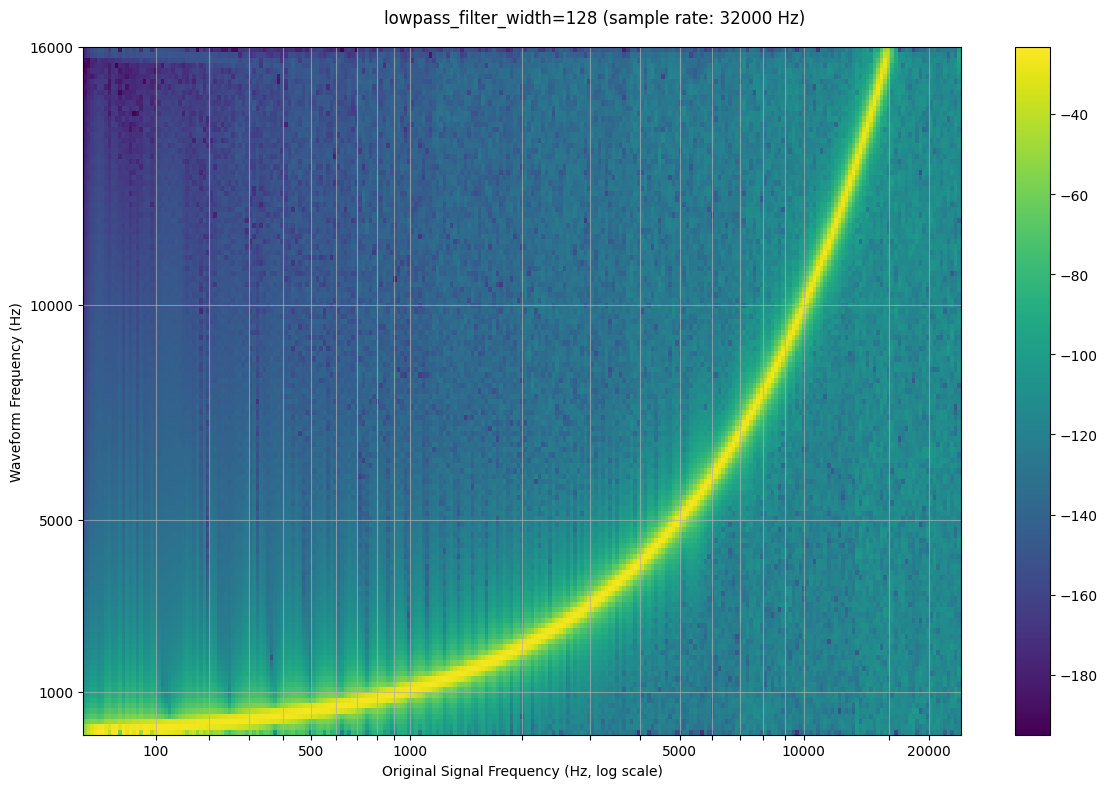

Sweep 시각화 완료!
lowpass_filter_width 비교 완료


In [425]:
# lowpass_filter_width 비교 (AIweek3.ipynb와 동일)
sample_rate = 48000
resample_rate = 32000

print("lowpass_filter_width 파라미터 비교")

# 좁은 필터 (width=6)
print(f"\nlowpass_filter_width=6 테스트:")
resampled_narrow = F.resample(waveform_sweep, sample_rate, resample_rate, lowpass_filter_width=6)
plot_sweep(resampled_narrow, resample_rate, title="lowpass_filter_width=6")

# 넓은 필터 (width=128)
print(f"\nlowpass_filter_width=128 테스트:")
resampled_wide = F.resample(waveform_sweep, sample_rate, resample_rate, lowpass_filter_width=128)
plot_sweep(resampled_wide, resample_rate, title="lowpass_filter_width=128")

print("lowpass_filter_width 비교 완료")


rolloff 파라미터 비교

 rolloff=0.99 테스트:
rolloff=0.99 Sweep 시각화 중...
NumPy 변환 실패, 리스트 변환 시도: Numpy is not available


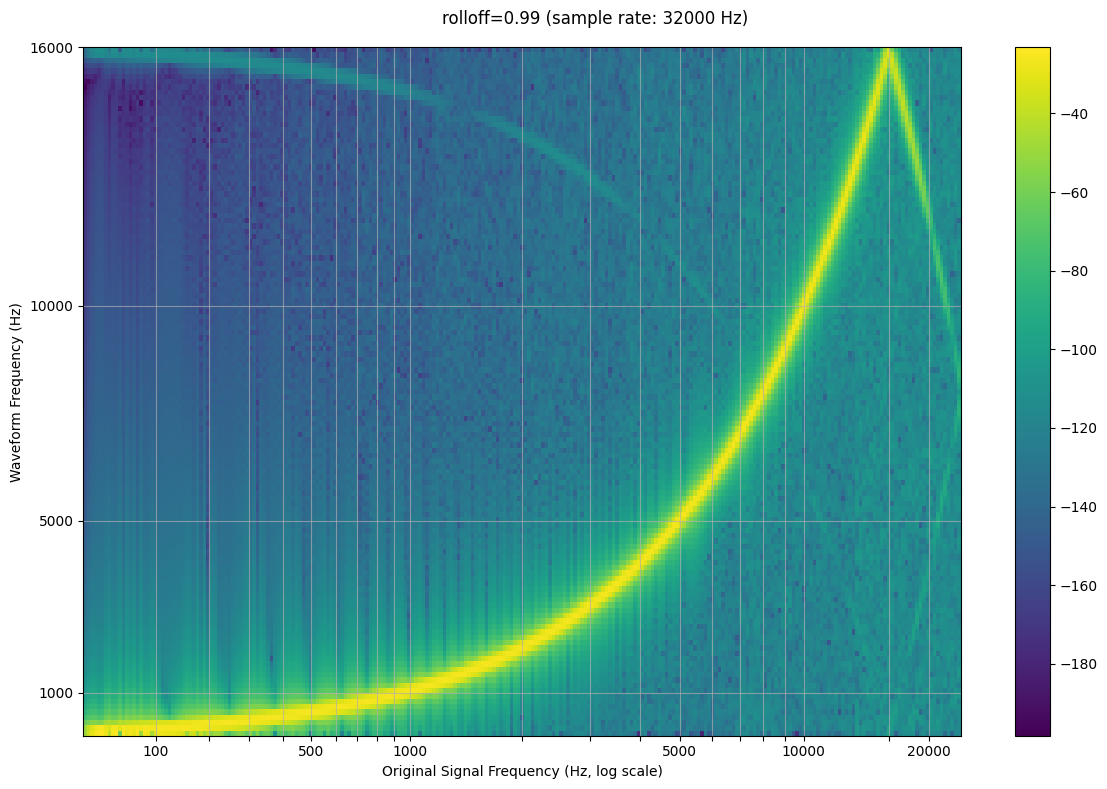

Sweep 시각화 완료!

 rolloff=0.8 테스트:
rolloff=0.8 Sweep 시각화 중...
NumPy 변환 실패, 리스트 변환 시도: Numpy is not available


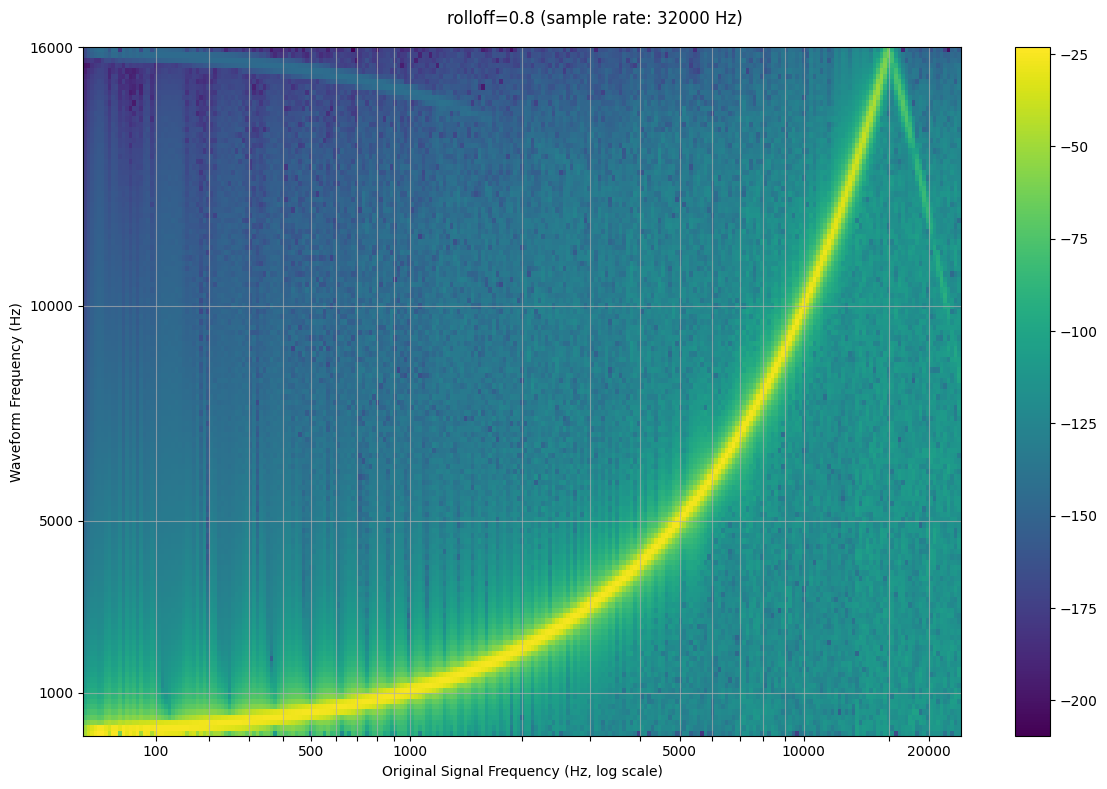

Sweep 시각화 완료!
rolloff 비교 완료


In [426]:
# rolloff 파라미터 비교 (AIweek3.ipynb와 동일)
print("rolloff 파라미터 비교")

# 높은 rolloff (0.99)
print(f"\n rolloff=0.99 테스트:")
resampled_high_rolloff = F.resample(waveform_sweep, sample_rate, resample_rate, rolloff=0.99)
plot_sweep(resampled_high_rolloff, resample_rate, title="rolloff=0.99")

# 낮은 rolloff (0.8)
print(f"\n rolloff=0.8 테스트:")
resampled_low_rolloff = F.resample(waveform_sweep, sample_rate, resample_rate, rolloff=0.8)
plot_sweep(resampled_low_rolloff, resample_rate, title="rolloff=0.8")

print("rolloff 비교 완료")


Hann Window Default Sweep 시각화 중...
NumPy 변환 실패, 리스트 변환 시도: Numpy is not available


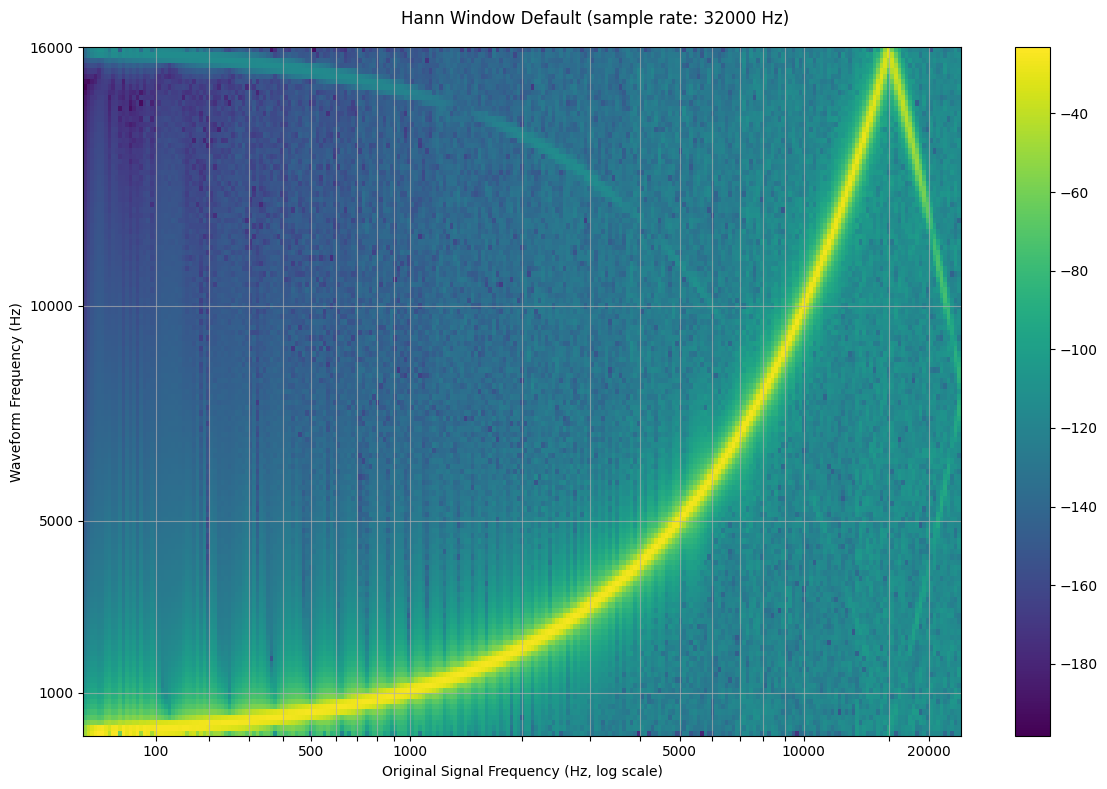

Sweep 시각화 완료!


In [433]:
resampled_hann = F.resample(waveform_sweep, sample_rate, resample_rate, resampling_method="sinc_interp_hann")
plot_sweep(resampled_hann, resample_rate, title="Hann Window Default")

In [434]:
# 버전 정보 확인 (AIweek3.ipynb와 동일)
print("라이브러리 버전 정보:")
print(f"torchaudio: {torchaudio.__version__}")
if LIBROSA_AVAILABLE:
    print(f"librosa: {librosa.__version__}")
    print(f"resampy: {resampy.__version__}")
else:
    print("librosa: 사용 불가")
    print("resampy: 사용 불가")
    
print(f"numpy: {np.__version__}")
print(f"pandas: {pd.__version__}")


라이브러리 버전 정보:
torchaudio: 2.8.0
librosa: 0.11.0
resampy: 0.4.3
numpy: 2.3.3
pandas: 2.3.2


In [435]:
# 벤치마크 함수들 정의 (AIweek3.ipynb 기반, MPS 최적화)
def benchmark_resample_functional(
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=6,
    rolloff=0.99,
    resampling_method="sinc_interp_hann",
    beta=None,
    iters=5,
):
    """TorchAudio Functional 리샘플링 벤치마크 (MPS 안전)"""
    # CPU로 이동 (벤치마크의 공정성을 위해)
    waveform_cpu = waveform.cpu() if waveform.device.type in ['mps', 'cuda'] else waveform
    
    return (
        timeit.timeit(
            stmt="""
torchaudio.functional.resample(
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=lowpass_filter_width,
    rolloff=rolloff,
    resampling_method=resampling_method,
    beta=beta,
)
        """,
            setup="import torchaudio",
            number=iters,
            globals={"torchaudio": torchaudio, "waveform": waveform_cpu, 
                    "sample_rate": sample_rate, "resample_rate": resample_rate,
                    "lowpass_filter_width": lowpass_filter_width, "rolloff": rolloff,
                    "resampling_method": resampling_method, "beta": beta},
        )
        * 1000
        / iters
    )

def benchmark_resample_transforms(
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=6,
    rolloff=0.99,
    resampling_method="sinc_interp_hann",
    beta=None,
    iters=5,
):
    """TorchAudio Transforms 리샘플링 벤치마크 (MPS 안전)"""
    # CPU로 이동 (벤치마크의 공정성을 위해)
    waveform_cpu = waveform.cpu() if waveform.device.type in ['mps', 'cuda'] else waveform
    
    return (
        timeit.timeit(
            stmt="resampler(waveform)",
            setup="""
import torchaudio

resampler = torchaudio.transforms.Resample(
    sample_rate,
    resample_rate,
    lowpass_filter_width=lowpass_filter_width,
    rolloff=rolloff,
    resampling_method=resampling_method,
    dtype=waveform.dtype,
    beta=beta,
)
        """,
            number=iters,
            globals={"torchaudio": torchaudio, "waveform": waveform_cpu,
                    "sample_rate": sample_rate, "resample_rate": resample_rate,
                    "lowpass_filter_width": lowpass_filter_width, "rolloff": rolloff,
                    "resampling_method": resampling_method, "beta": beta},
        )
        * 1000
        / iters
    )

def benchmark_resample_librosa(
    waveform,
    sample_rate,
    resample_rate,
    res_type,
    iters=5,
):
    """Librosa 리샘플링 벤치마크 (MPS 안전)"""
    if not LIBROSA_AVAILABLE:
        return float('inf')  # librosa 없으면 무한대 반환
    
    # NumPy 변환
    waveform_np = safe_numpy_convert(waveform)
    if len(waveform_np.shape) > 1:
        waveform_np = waveform_np[0]
    
    return (
        timeit.timeit(
            stmt="librosa.resample(waveform, orig_sr=sample_rate, target_sr=resample_rate, res_type=res_type)",
            setup="import librosa",
            number=iters,
            globals={"librosa": librosa, "waveform": waveform_np,
                    "sample_rate": sample_rate, "resample_rate": resample_rate, "res_type": res_type},
        )
        * 1000
        / iters
    )

print("벤치마크 함수들 정의 완료")


벤치마크 함수들 정의 완료


In [439]:
# 포괄적인 벤치마크 함수 (AIweek3.ipynb 기반)
def benchmark(sample_rate, resample_rate):
    """포괄적인 리샘플링 벤치마크"""
    times, rows = [], []
    waveform = get_sine_sweep(sample_rate).to(torch.float32)

    args = (waveform, sample_rate, resample_rate)

    # sinc 64 zero-crossings
    f_time = benchmark_resample_functional(*args, lowpass_filter_width=64)
    t_time = benchmark_resample_transforms(*args, lowpass_filter_width=64)
    times.append([None, f_time, t_time])
    rows.append("sinc (width 64)")

    # sinc 16 zero-crossings
    f_time = benchmark_resample_functional(*args, lowpass_filter_width=16)
    t_time = benchmark_resample_transforms(*args, lowpass_filter_width=16)
    times.append([None, f_time, t_time])
    rows.append("sinc (width 16)")

    # kaiser best
    kwargs = {
        "lowpass_filter_width": 64,
        "rolloff": 0.9475937167399596,
        "resampling_method": "sinc_interp_kaiser",
        "beta": 14.769656459379492,
    }
    lib_time = benchmark_resample_librosa(*args, res_type="kaiser_best")
    f_time = benchmark_resample_functional(*args, **kwargs)
    t_time = benchmark_resample_transforms(*args, **kwargs)
    times.append([lib_time, f_time, t_time])
    rows.append("kaiser_best")

    # kaiser fast
    kwargs = {
        "lowpass_filter_width": 16,
        "rolloff": 0.85,
        "resampling_method": "sinc_interp_kaiser",
        "beta": 8.555504641634386,
    }
    lib_time = benchmark_resample_librosa(*args, res_type="kaiser_fast")
    f_time = benchmark_resample_functional(*args, **kwargs)
    t_time = benchmark_resample_transforms(*args, **kwargs)
    times.append([lib_time, f_time, t_time])
    rows.append("kaiser_fast")

    df = pd.DataFrame(times, columns=["librosa", "functional", "transforms"], index=rows)
    return df

def plot(df):
    """벤치마크 결과 시각화"""
    print("\n벤치마크 결과:")
    print("=" * 50)
    print(df.round(2))
    
    plt.figure(figsize=(12, 8))
    ax = df.plot(kind="bar", figsize=(12, 8))
    plt.ylabel("Time Elapsed [ms]")
    plt.xlabel("Resampling Method")
    plt.title("Resampling Performance Comparison (Apple Silicon MPS)")
    plt.xticks(rotation=45, fontsize=10)
    plt.legend(title="Implementation")
    
    # 막대 위에 값 표시
    for cont, col, color in zip(ax.containers, df.columns, mcolors.TABLEAU_COLORS):
        label = ["N/A" if pd.isna(v) or np.isinf(v) else str(round(v, 2)) for v in df[col]]
        ax.bar_label(cont, labels=label, color=color, fontweight="bold", fontsize="x-small")
    
    plt.tight_layout()
    plt.show()
    
    # 최고 성능 분석
    print("\n성능 분석:")
    for idx, row in df.iterrows():
        valid_times = row.dropna()
        valid_times = valid_times[~np.isinf(valid_times)]  # 무한대 제거
        if len(valid_times) > 0:
            fastest = valid_times.idxmin()
            fastest_time = valid_times.min()
            print(f"  {idx}: {fastest} ({fastest_time:.2f}ms)")
        else:
            print(f"  {idx}: 모든 방법 실패")

print("포괄적인 벤치마크 함수 정의 완료")


포괄적인 벤치마크 함수 정의 완료


=== 리샘플링 성능 벤치마크 실행 ===
Apple Silicon MPS 최적화 버전
NumPy 변환 실패, 리스트 변환 시도: Numpy is not available
NumPy 변환 실패, 리스트 변환 시도: Numpy is not available

벤치마크 결과:
                 librosa  functional  transforms
sinc (width 64)      NaN        1.12        0.60
sinc (width 16)      NaN        0.26        0.16
kaiser_best         4.23        0.52        0.39
kaiser_fast         1.15        0.27        0.21


<Figure size 1200x800 with 0 Axes>

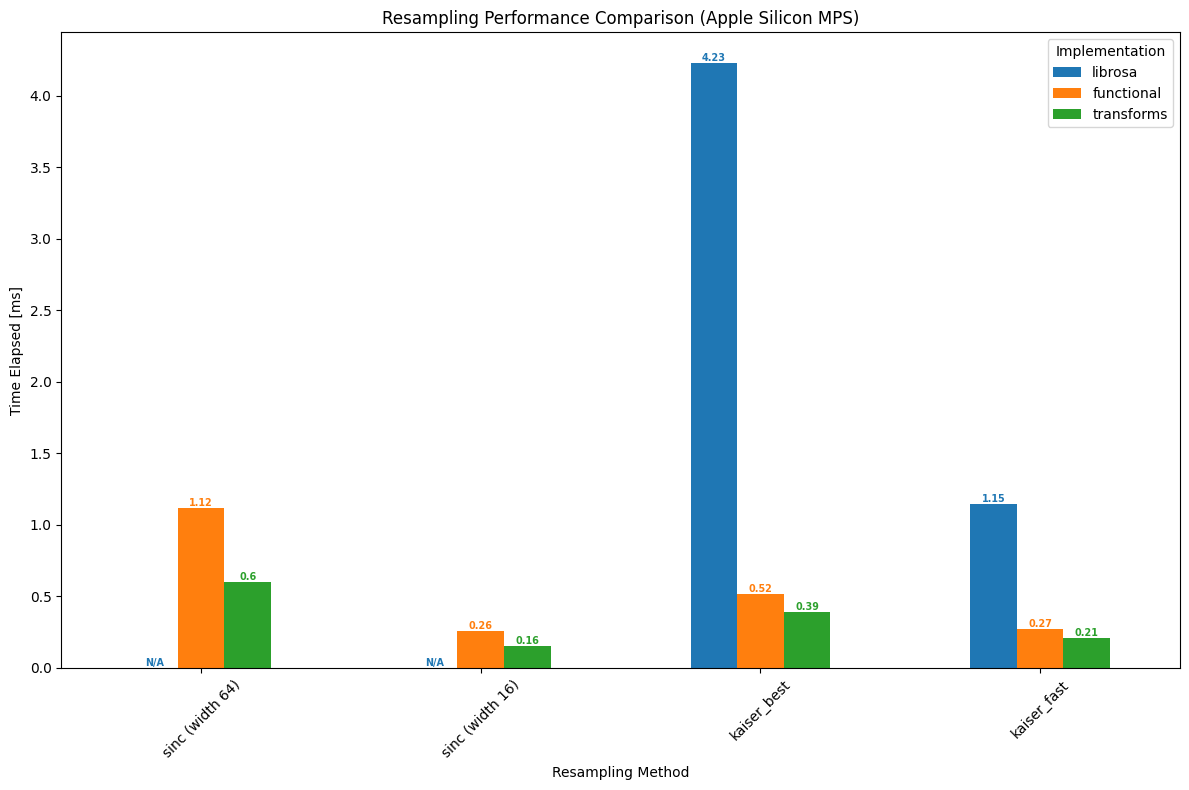


성능 분석:
  sinc (width 64): transforms (0.60ms)
  sinc (width 16): transforms (0.16ms)
  kaiser_best: transforms (0.39ms)
  kaiser_fast: transforms (0.21ms)


In [440]:
# 벤치마크 실행 (16kHz → 8kHz) - AIweek3.ipynb와 동일
print("=== 리샘플링 성능 벤치마크 실행 ===")
print("Apple Silicon MPS 최적화 버전")

df = benchmark(16_000, 8_000)
plot(df)


=== 업샘플링 벤치마크 ===
NumPy 변환 실패, 리스트 변환 시도: Numpy is not available
NumPy 변환 실패, 리스트 변환 시도: Numpy is not available

벤치마크 결과:
                 librosa  functional  transforms
sinc (width 64)      NaN        0.24        0.10
sinc (width 16)      NaN        0.11        0.08
kaiser_best        14.31        0.70        0.41
kaiser_fast         1.51        0.14        0.06


<Figure size 1200x800 with 0 Axes>

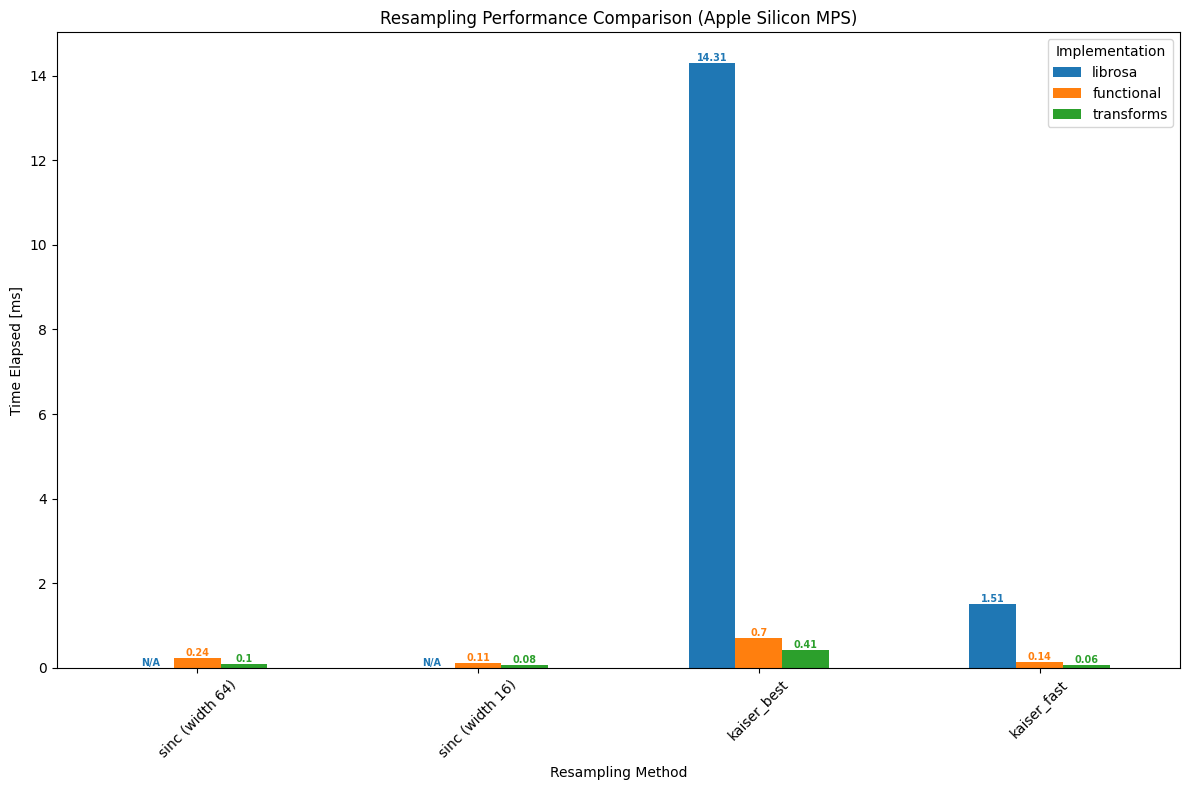


성능 분석:
  sinc (width 64): transforms (0.10ms)
  sinc (width 16): transforms (0.08ms)
  kaiser_best: transforms (0.41ms)
  kaiser_fast: transforms (0.06ms)


In [441]:
# 추가 벤치마크 (8kHz → 16kHz) - AIweek3.ipynb와 동일
print("=== 업샘플링 벤치마크 ===")

df = benchmark(8_000, 16_000)
plot(df)
